# `YPlusModel` Tutorial

Trey V. Wenger (c) August 2024

Here we demonstrate the basic features of the `YPlusModel` model. The `YPlusModel` models the radio recombiation line emission to infer `y+`, the helium abundance by number.

In [1]:
# General imports    
import os
import pickle
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import bayes_yplus
print("bayes_yplus version:", bayes_yplus.__version__)

from bayes_yplus import YPlusModel

# Notebook configuration
pd.options.display.max_rows = None
    
# random state
rng = np.random.RandomState(seed=1234)

pymc version: 5.16.2
bayes_spec version: 1.5.0+6.g3c38c15
bayes_yplus version: 1.0.0+2.g167b914.dirty


## Simulating Data

To test the model, we must simulate some data. We can do this with `YPlusModel`, but we must pack a "dummy" data structure first. The model expects the observation to be named `"observation"`.

Text(0, 0.5, 'Brightness Temperature (mK)')

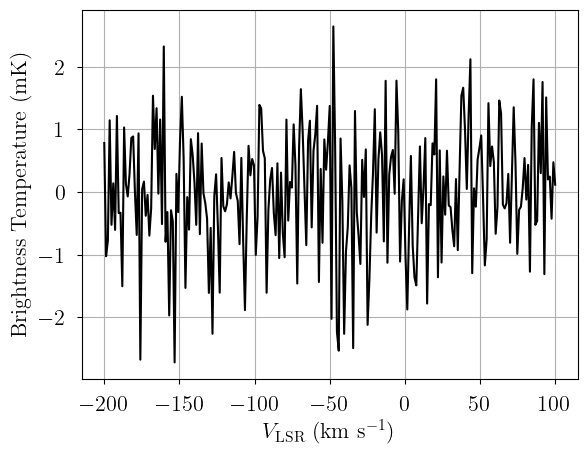

In [2]:
from bayes_spec import SpecData

# spectral axis definition
spec_axis = np.linspace(-200.0, 100.0, 251) # km s-1

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
noise = 1.0 # mK

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
brightness_data = noise * np.random.randn(len(spec_axis)) # mK

# HFSModel only expects a single observation named "observation"
observation = SpecData(
    spec_axis,
    brightness_data,
    noise,
    xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
    ylabel="Brightness Temperature (mK)",
)
dummy_data = {"observation": observation}

# Plot the dummy data
plt.plot(dummy_data["observation"].spectral, dummy_data["observation"].brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
plt.ylabel(dummy_data["observation"].ylabel)

Now that we have a dummy data format, we can generate a simulated observation by evaluating the likelihood for a given set of model parameters.

Text(0, 0.5, 'Brightness Temperature (mK)')

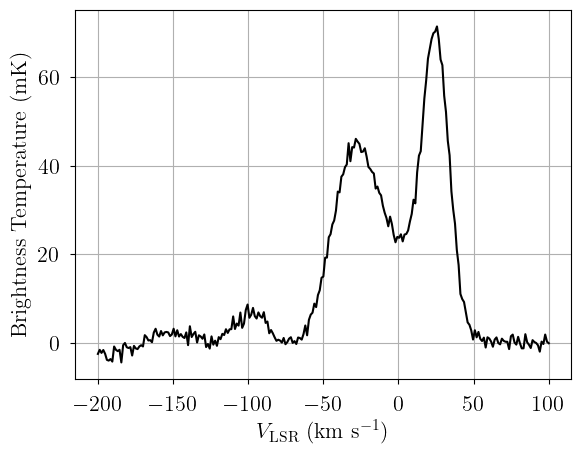

In [3]:
# Initialize and define the model
n_clouds = 3
baseline_degree = 2
model = YPlusModel(
    dummy_data,
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_H_area = 1000.0, # mode of H_area prior (mK km s-1)
    prior_H_center = [0.0, 25.0], # H_center prior (km s-1)
    prior_H_fwhm = 20.0, # H FWHM line width prior (km s-1)
    prior_He_H_fwhm_ratio = 0.1, # He/H FWHM ratio prior
    prior_yplus = 0.1, # mode of yplus prior
    prior_rms = 1.0, # width of spectral rms prior (mK)
    prior_baseline_coeffs = [1.0, 1.0, 1.0], # width of normalized baseline coefficients
    ordered = False, # do not assume ordered velocities
)
model.add_likelihood()

sim_brightness = model.model.observation.eval({
    "H_area": [1500.0, 1000.0, 1250.0],
    "H_center": [-30.0, 5.0, 25.0],
    "H_fwhm": [35.0, 50.0, 20.0],
    "He_H_fwhm_ratio": [1.0, 0.8, 1.25],
    "yplus": [0.1, 0.05, 0.15],
    "rms_observation": noise,
    "observation_baseline_norm": [-1.0, 2.0, -2.5], # normalized baseline coefficients
})

# Plot the simulated data
plt.plot(dummy_data["observation"].spectral, sim_brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
plt.ylabel(dummy_data["observation"].ylabel)

In [4]:
# Now we pack the simulated spectrum into a new SpecData instance
observation = SpecData(
    spec_axis,
    sim_brightness,
    noise,
    xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
    ylabel="Brightness Temperature (mK)",
)
data = {"observation": observation}

## Model Definition

Finally, with our model definition and (simulated) data in hand, we can explore the capabilities of `YPlusModel`. Here we create a new model with the simulated data.

In [5]:
# Initialize and define the model
model = YPlusModel(
    data,
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_H_area = 1000.0, # mode of H_area prior (mK km s-1)
    prior_H_center = [0.0, 25.0], # H_center prior (km s-1)
    prior_H_fwhm = 20.0, # H FWHM line width prior (km s-1)
    prior_He_H_fwhm_ratio = 0.1, # He/H FWHM ratio prior
    prior_yplus = 0.1, # mode of yplus prior
    prior_rms = 1.0, # width of spectral rms prior (mK)
    prior_baseline_coeffs = [1.0, 1.0, 1.0], # width of normalized baseline coefficients
    ordered = False, # do not assume ordered velocities
)
model.add_likelihood()

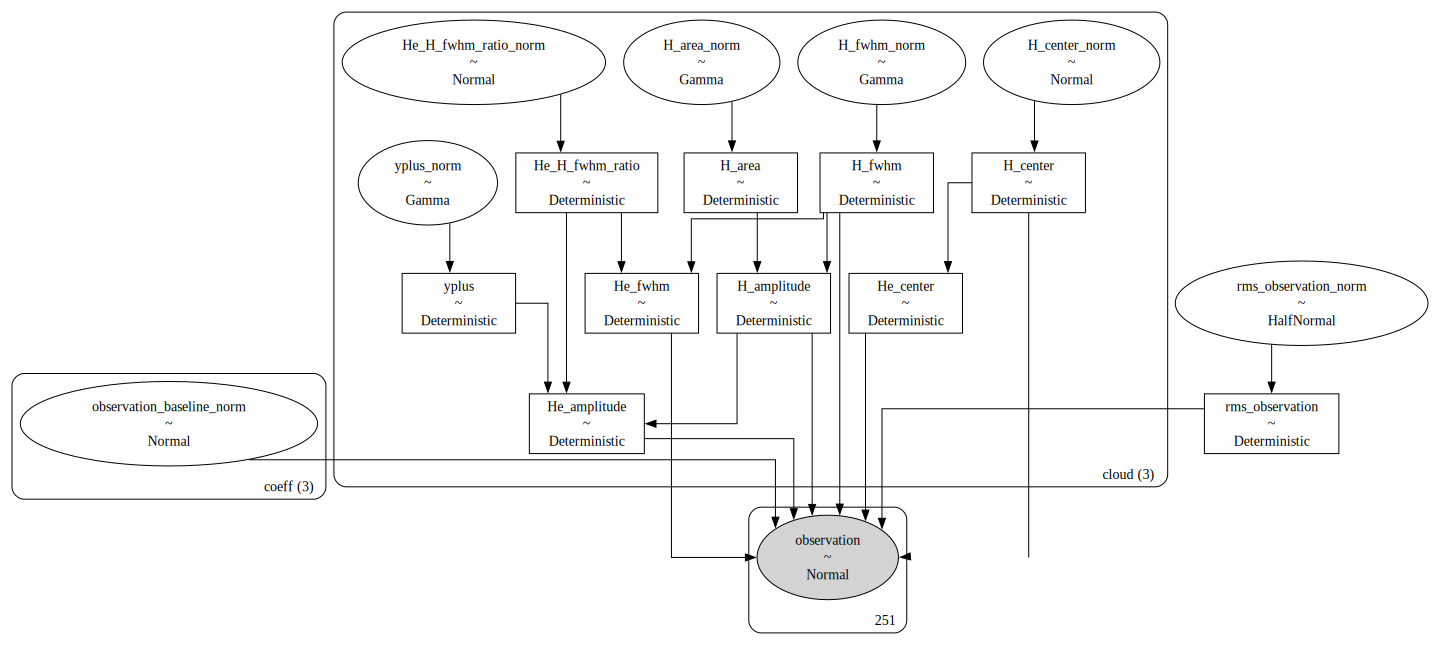

In [6]:
# Plot model graph
model.graph().render("yplus_model", format="png")
model.graph()

In [7]:
# model string representation
print(model.model.str_repr())

observation_baseline_norm ~ Normal(0, <constant>)
              H_area_norm ~ Gamma(2, f())
            H_center_norm ~ Normal(0, 1)
              H_fwhm_norm ~ Gamma(3, f())
     He_H_fwhm_ratio_norm ~ Normal(0, 1)
               yplus_norm ~ Gamma(3, f())
     rms_observation_norm ~ HalfNormal(0, 1)
                   H_area ~ Deterministic(f(H_area_norm))
                 H_center ~ Deterministic(f(H_center_norm))
                   H_fwhm ~ Deterministic(f(H_fwhm_norm))
          He_H_fwhm_ratio ~ Deterministic(f(He_H_fwhm_ratio_norm))
                    yplus ~ Deterministic(f(yplus_norm))
          rms_observation ~ Deterministic(f(rms_observation_norm))
              H_amplitude ~ Deterministic(f(H_fwhm_norm, H_area_norm))
             He_amplitude ~ Deterministic(f(He_H_fwhm_ratio_norm, yplus_norm, H_fwhm_norm, H_area_norm))
                He_center ~ Deterministic(f(H_center_norm))
                  He_fwhm ~ Deterministic(f(H_fwhm_norm, He_H_fwhm_ratio_norm))
              

We check that our prior distributions are reasonable by drawing prior predictive checks. Each colored line is a simulated "observation" with parameters drawn from the prior distributions. You should check that these simulated observations at least somewhat overlap your actual observation (black line).

Sampling: [H_area_norm, H_center_norm, H_fwhm_norm, He_H_fwhm_ratio_norm, observation, observation_baseline_norm, rms_observation_norm, yplus_norm]


array([[<Axes: xlabel='$V_{\\rm LSR}$ (km s$^{-1}$)', ylabel='Brightness Temperature (mK)'>]],
      dtype=object)

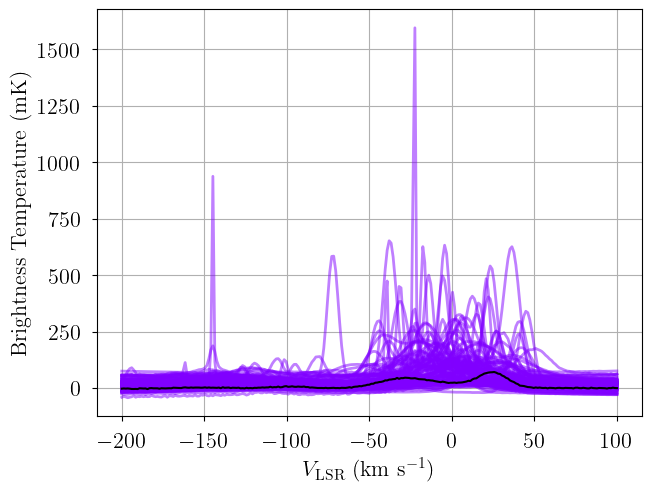

In [8]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
plot_predictive(model.data, prior.prior_predictive)

array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='$V_{\\rm LSR, H}$ (km s$^{-1}$)'>, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: ylabel='$\\Delta V_{\\rm H}$ (km s$^{-1}$)'>, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: ylabel='$\\Delta V_{\\rm He}/\\Delta V_{\\rm H}$'>,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='$y^+$'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='$T_{L,\\rm H}$'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='$T_{L,\\rm He}$'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='$V_{\\rm LS

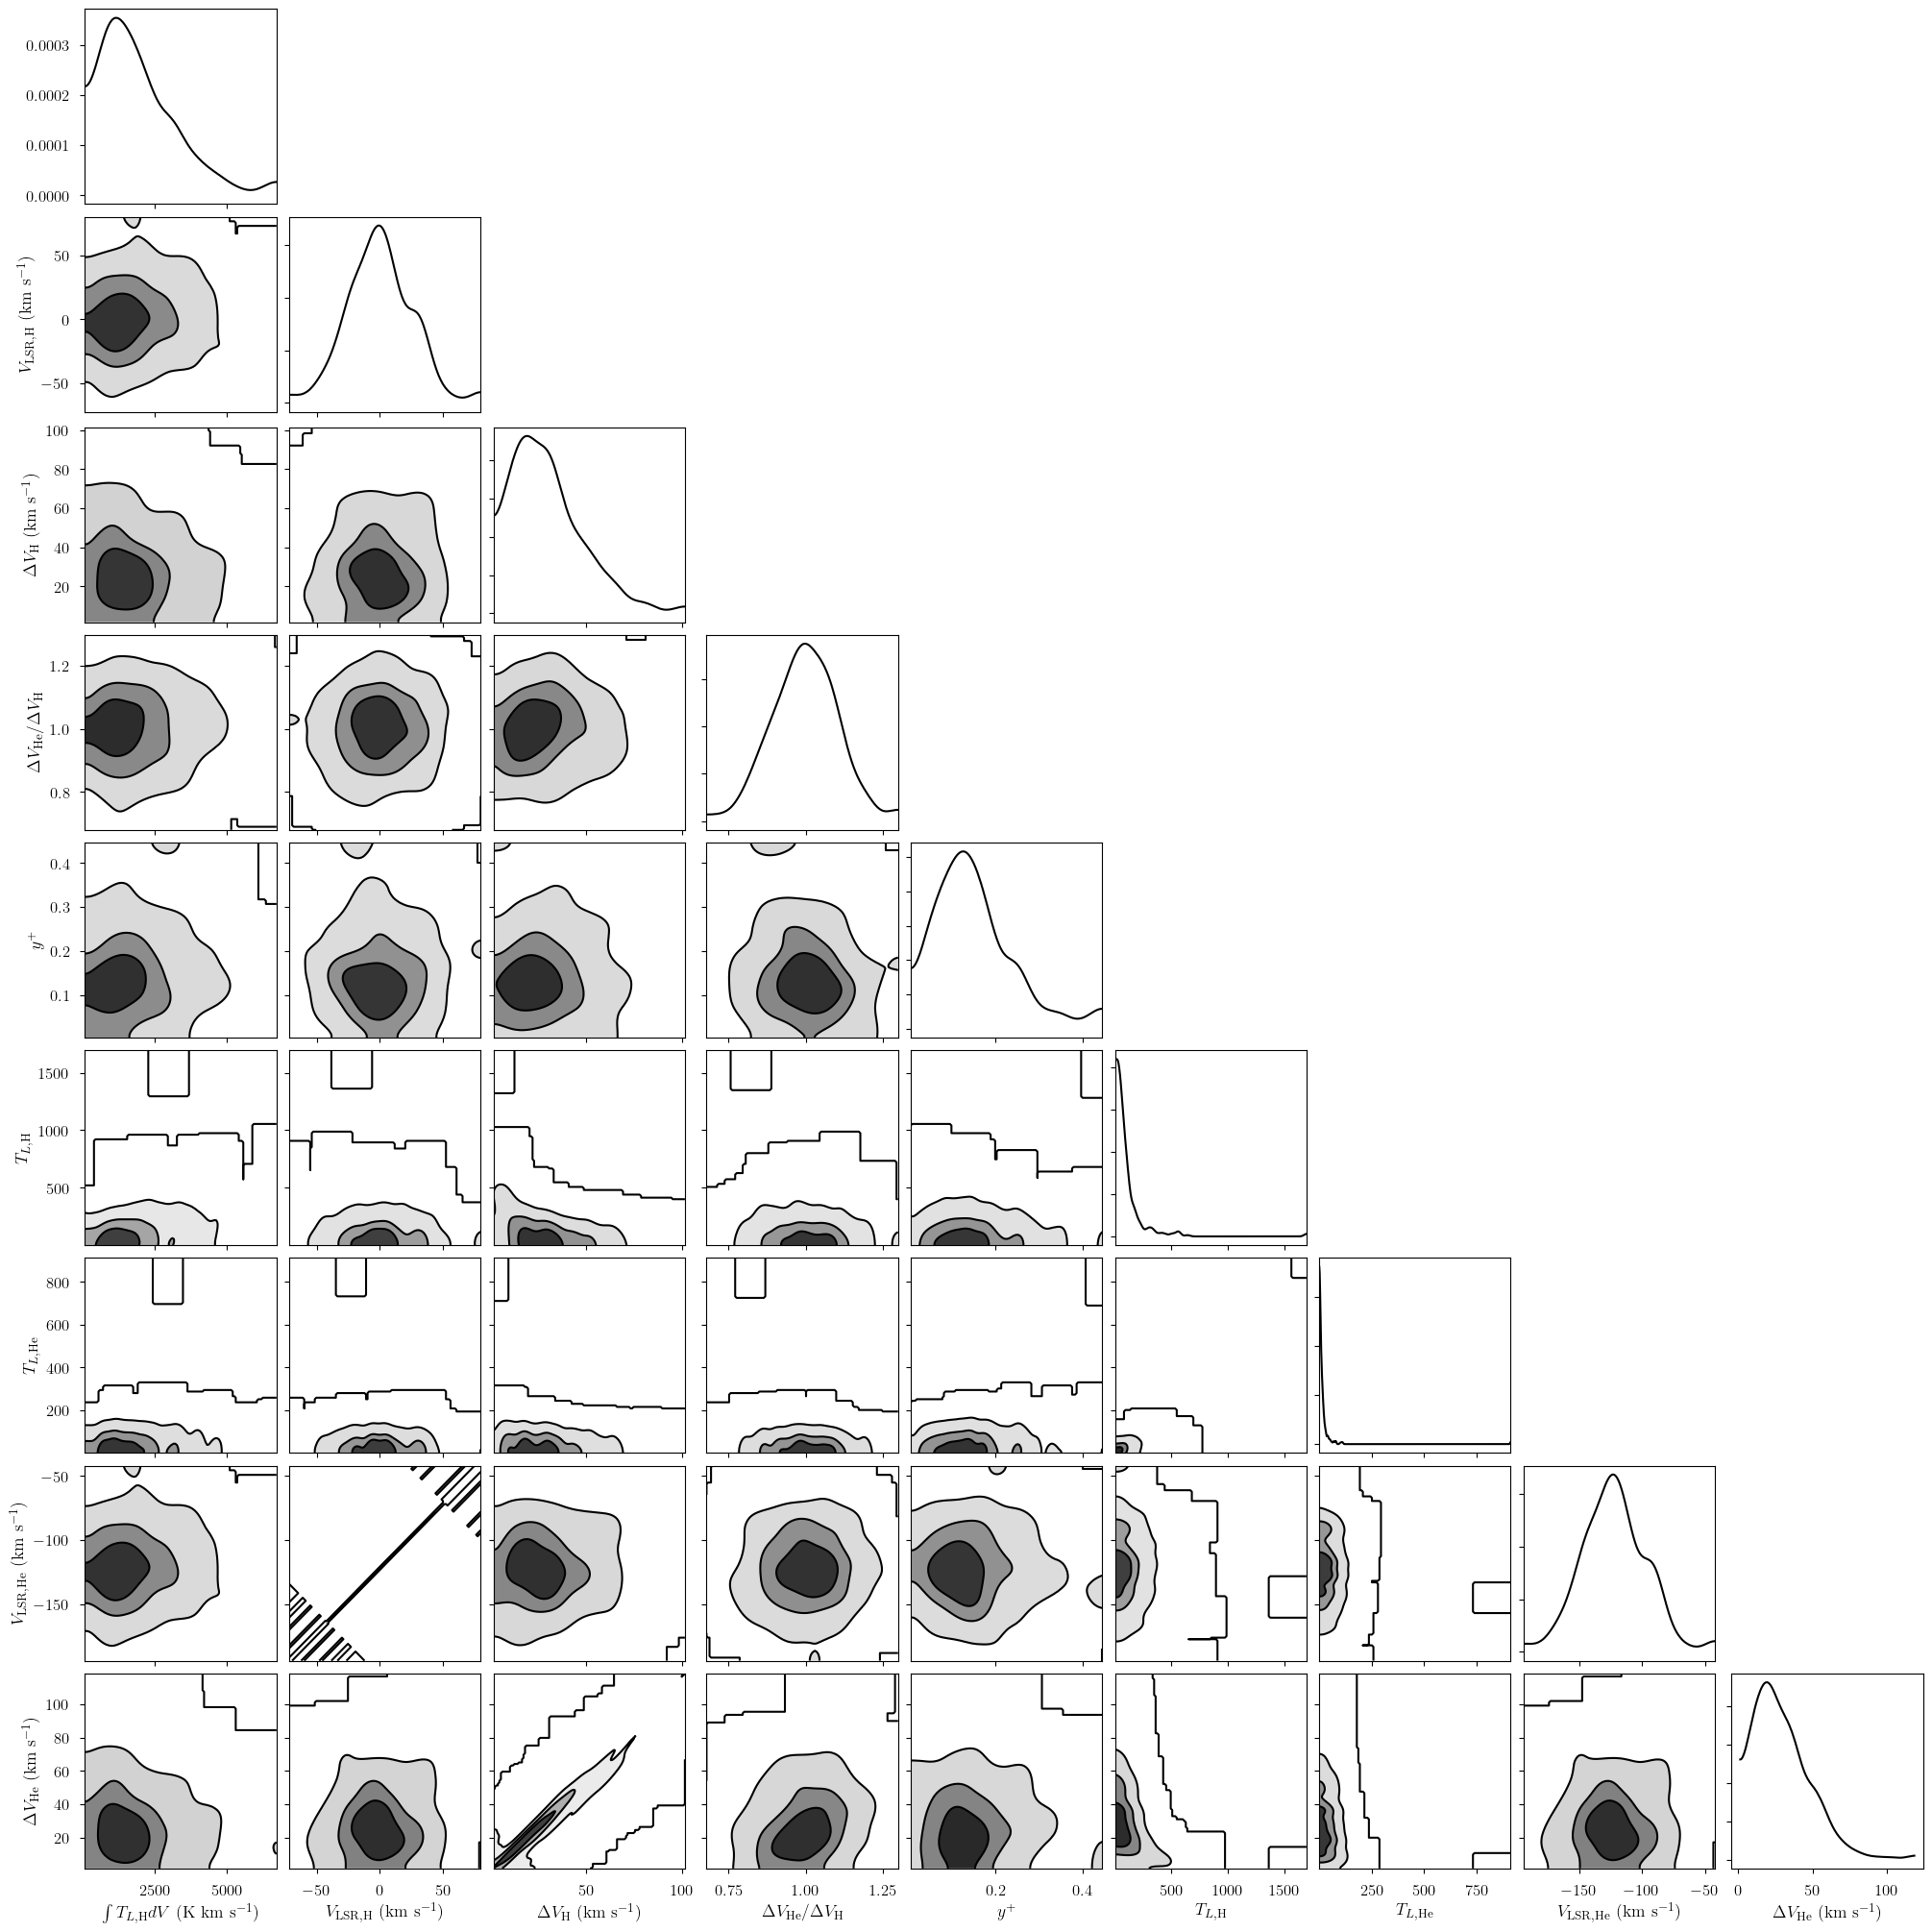

In [9]:
from bayes_spec.plots import plot_pair

var_names = [param for param in model.deterministics if "rms" not in param]
plot_pair(
    prior.prior, # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
)

## Variational Inference

We can approximate the posterior distribution using variational inference.

In [10]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 1e-2, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 3600
Interrupted at 3,599 [3%]: Average Loss = 18,540


Runtime: 0.13 minutes


In [11]:
pm.summary(model.trace.posterior, var_names=model.deterministics)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
H_area[0],1296.470,12.173,1271.919,1317.165,0.404,0.286,903.0,843.0,NaN
H_area[1],1026.575,14.798,998.328,1053.240,0.461,0.326,1028.0,941.0,NaN
H_area[2],1360.204,9.743,1340.225,1376.420,0.307,0.217,1005.0,1017.0,NaN
H_center[0],-30.931,0.161,-31.262,-30.665,0.005,0.004,909.0,907.0,NaN
H_center[1],-2.564,0.476,-3.512,-1.681,0.016,0.011,893.0,918.0,NaN
H_center[2],24.961,0.080,24.804,25.103,0.003,0.002,929.0,907.0,NaN
H_fwhm[0],33.224,0.344,32.630,33.912,0.011,0.007,1079.0,973.0,NaN
H_fwhm[1],49.280,0.803,47.690,50.766,0.024,0.017,1093.0,944.0,NaN
H_fwhm[2],20.569,0.143,20.307,20.833,0.005,0.003,883.0,943.0,NaN
He_H_fwhm_ratio[0],1.001,0.069,0.864,1.118,0.002,0.002,863.0,924.0,NaN


Sampling: [observation]


Output()

array([[<Axes: xlabel='$V_{\\rm LSR}$ (km s$^{-1}$)', ylabel='Brightness Temperature (mK)'>]],
      dtype=object)

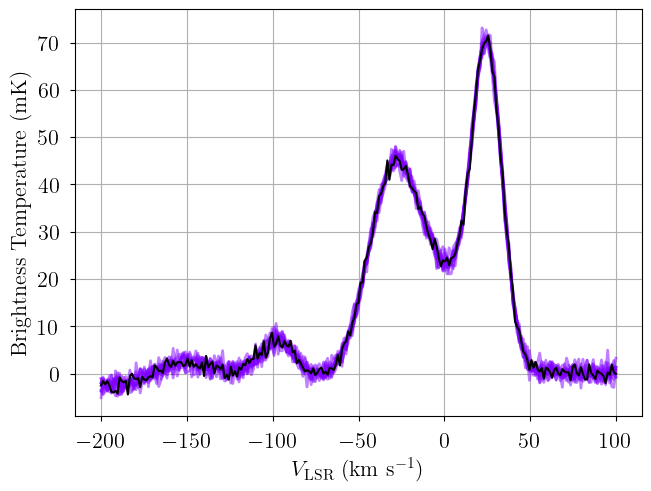

In [12]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
plot_predictive(model.data, posterior.posterior_predictive)

## Posterior Sampling: MCMC

We can sample from the posterior distribution using MCMC.

In [13]:
start = time.time()
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 4, # number of independent chains
    cores = 4, # number of parallel chains
    init_kwargs = {"rel_tolerance": 0.01, "abs_tolerance": 0.1, "learning_rate": 1e-2}, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 3600
Interrupted at 3,599 [3%]: Average Loss = 18,540
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [observation_baseline_norm, H_area_norm, H_center_norm, H_fwhm_norm, He_H_fwhm_ratio_norm, yplus_norm, rms_observation_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 83 seconds.


Runtime: 1.73 minutes


In [14]:
model.solve(p_threshold=0.9)

GMM converged to unique solution


In [15]:
pm.summary(model.trace.solution_0, var_names=model.deterministics)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
H_area[0],1284.432,180.367,966.103,1626.610,5.414,3.877,1116.0,1369.0,1.0
H_area[1],1098.851,188.457,776.966,1468.237,5.736,4.057,1081.0,1463.0,1.0
H_area[2],1360.793,62.766,1241.235,1481.303,1.852,1.313,1175.0,1525.0,1.0
H_center[0],-30.919,0.700,-32.298,-29.560,0.020,0.014,1188.0,1632.0,1.0
H_center[1],-2.940,4.643,-11.344,5.575,0.140,0.099,1127.0,1411.0,1.0
H_center[2],24.950,0.095,24.773,25.136,0.002,0.001,2461.0,2344.0,1.0
H_fwhm[0],33.513,1.285,31.013,35.825,0.036,0.026,1265.0,1530.0,1.0
H_fwhm[1],50.679,5.426,40.529,61.137,0.168,0.119,1062.0,1219.0,1.0
H_fwhm[2],20.571,0.382,19.893,21.343,0.010,0.007,1352.0,1772.0,1.0
He_H_fwhm_ratio[0],1.023,0.081,0.886,1.193,0.002,0.001,2887.0,2945.0,1.0


In [16]:
print("solutions:", model.solutions)
display(az.summary(model.trace["solution_0"]))
# this also works: az.summary(model.trace.solution_0)

solutions: [0]


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
H_amplitude[0],35.880,3.851,29.026,42.871,0.116,0.083,1108.0,1390.0,1.0
H_amplitude[1],20.263,1.800,17.238,23.752,0.051,0.036,1267.0,1839.0,1.0
H_amplitude[2],62.115,1.823,58.802,65.762,0.054,0.038,1186.0,1512.0,1.0
H_area[0],1284.432,180.367,966.103,1626.610,5.414,3.877,1116.0,1369.0,1.0
H_area[1],1098.851,188.457,776.966,1468.237,5.736,4.057,1081.0,1463.0,1.0
H_area[2],1360.793,62.766,1241.235,1481.303,1.852,1.313,1175.0,1525.0,1.0
H_area_norm[0],1.284,0.180,0.966,1.627,0.005,0.004,1116.0,1369.0,1.0
H_area_norm[1],1.099,0.188,0.777,1.468,0.006,0.004,1081.0,1463.0,1.0
H_area_norm[2],1.361,0.063,1.241,1.481,0.002,0.001,1175.0,1525.0,1.0
H_center[0],-30.919,0.700,-32.298,-29.560,0.020,0.014,1188.0,1632.0,1.0


We generate posterior predictive checks as well as a trace plot of the individual chains. In the posterior predictive plot, we show each chain as a different color. Each line is one posterior sample.

Sampling: [observation]


Output()

array([[<Axes: xlabel='$V_{\\rm LSR}$ (km s$^{-1}$)', ylabel='Brightness Temperature (mK)'>]],
      dtype=object)

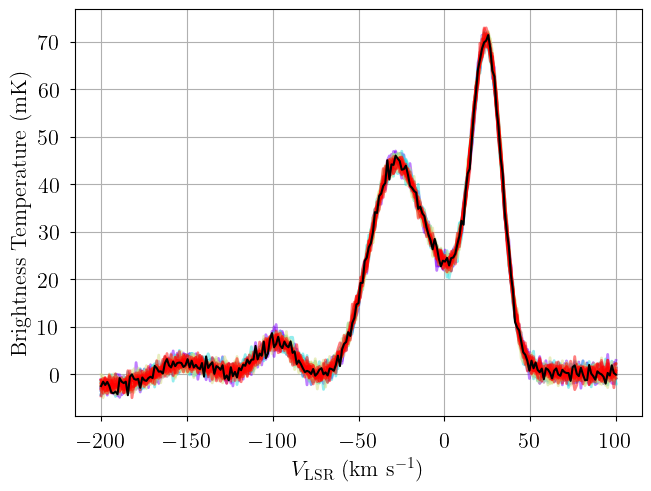

In [17]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
plot_predictive(model.data, posterior.posterior_predictive)

array([[<Axes: title={'center': 'H_area_norm'}>,
        <Axes: title={'center': 'H_area_norm'}>],
       [<Axes: title={'center': 'H_center_norm'}>,
        <Axes: title={'center': 'H_center_norm'}>],
       [<Axes: title={'center': 'H_fwhm_norm'}>,
        <Axes: title={'center': 'H_fwhm_norm'}>],
       [<Axes: title={'center': 'He_H_fwhm_ratio_norm'}>,
        <Axes: title={'center': 'He_H_fwhm_ratio_norm'}>],
       [<Axes: title={'center': 'yplus_norm'}>,
        <Axes: title={'center': 'yplus_norm'}>],
       [<Axes: title={'center': 'observation_baseline_norm'}>,
        <Axes: title={'center': 'observation_baseline_norm'}>],
       [<Axes: title={'center': 'rms_observation_norm'}>,
        <Axes: title={'center': 'rms_observation_norm'}>]], dtype=object)

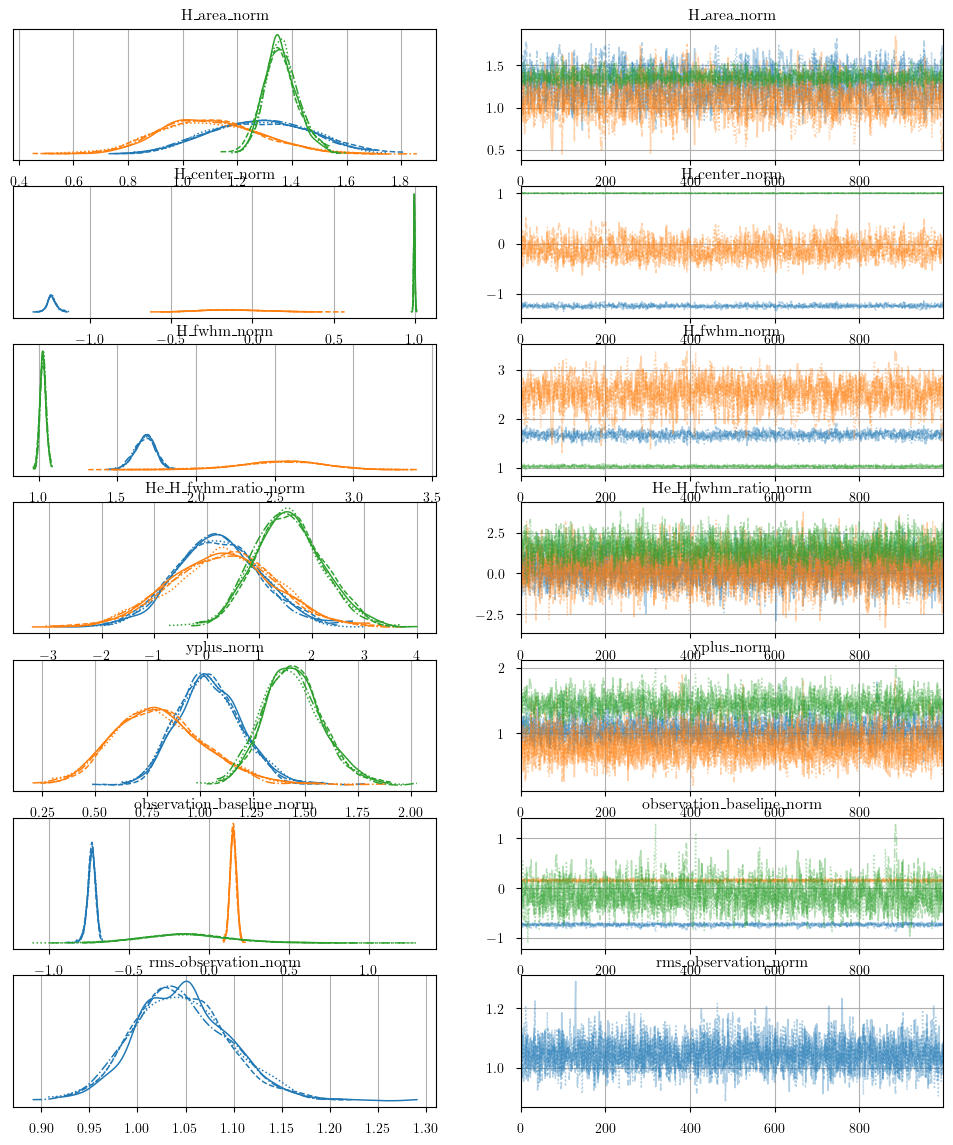

In [18]:
from bayes_spec.plots import plot_traces

plot_traces(model.trace.solution_0, model.cloud_params+model.baseline_params+model.hyper_params)

We can inspect the posterior distribution pair plots. First, the normalized, free cloud parameters.

array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='$V_{\\rm LSR, H}$ (km s$^{-1}$)'>, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: ylabel='$\\Delta V_{\\rm H}$ (km s$^{-1}$)'>, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: ylabel='$\\Delta V_{\\rm He}/\\Delta V_{\\rm H}$'>,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='$y^+$'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='$T_{L,\\rm H}$'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='$T_{L,\\rm He}$'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='$V_{\\rm LS

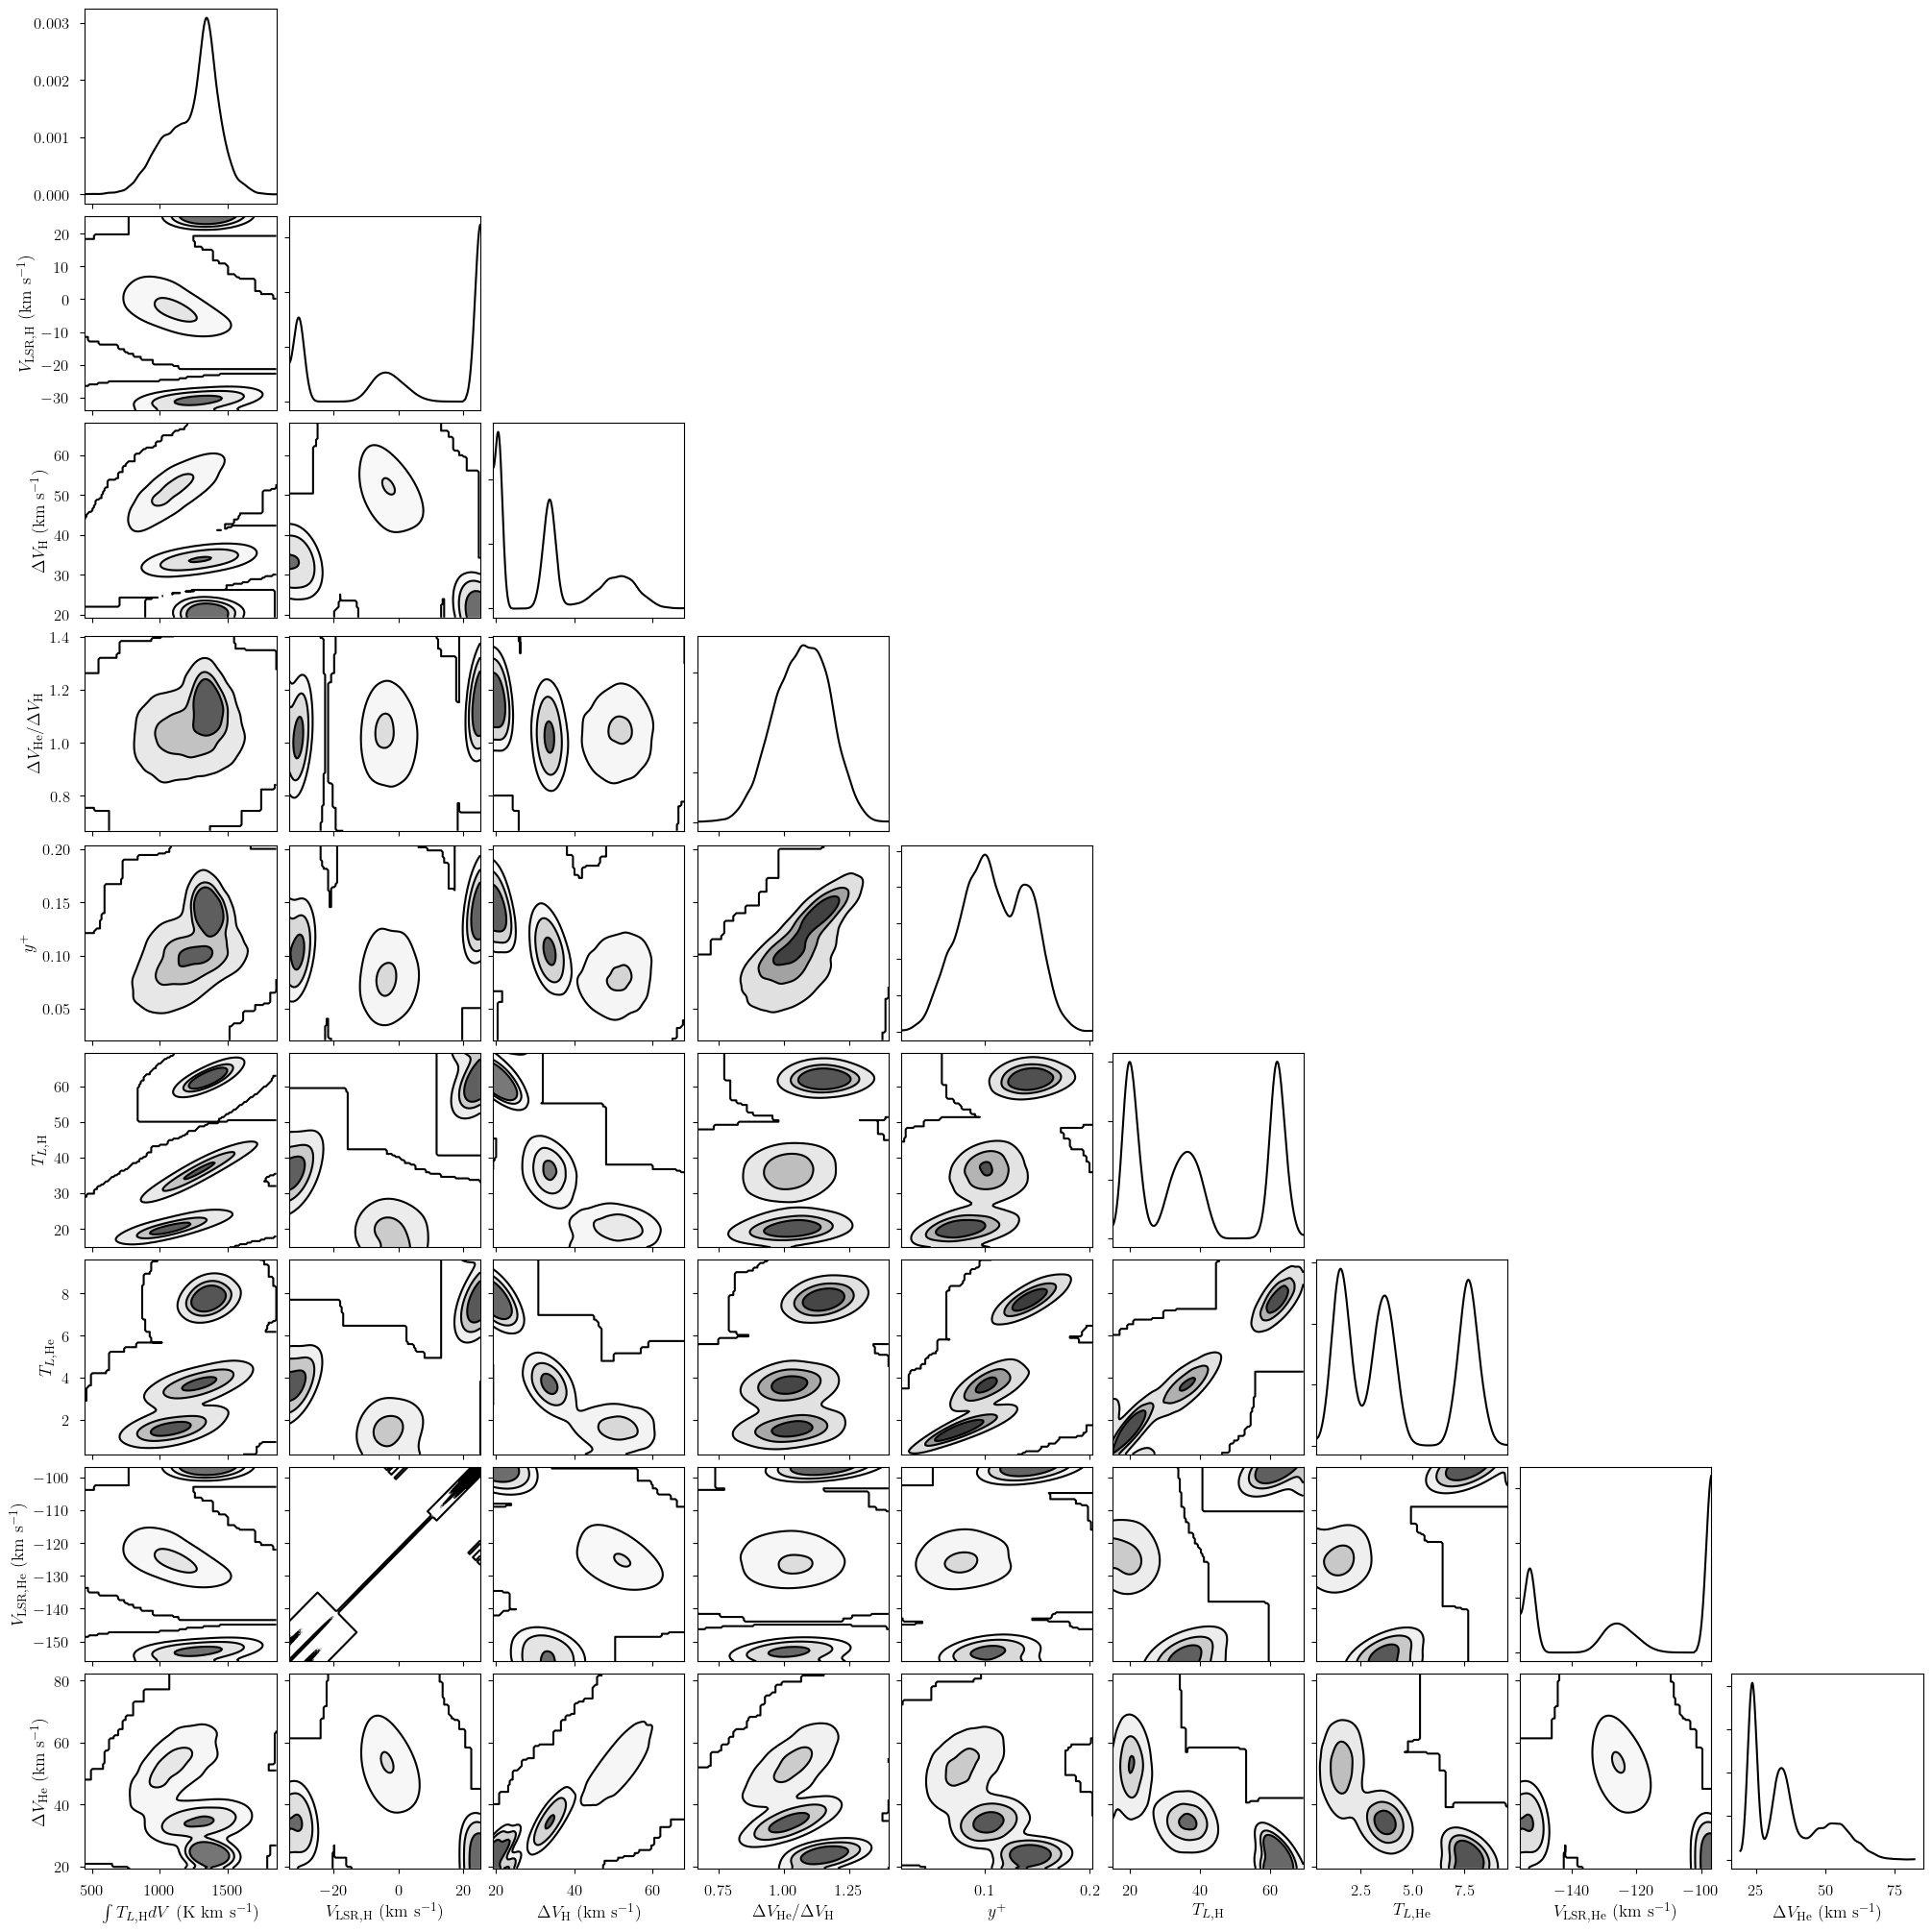

In [19]:
var_names = [param for param in model.deterministics if "rms" not in param]
plot_pair(
    model.trace.solution_0, # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
)

Notice that there are three posterior modes. These correspond to the three clouds of the model. We can plot the posterior distributions of the deterministic quantities for a single cloud (excluding the spectral rms hyper parameter).

array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='$V_{\\rm LSR, H}$ (km s$^{-1}$)'>, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: ylabel='$\\Delta V_{\\rm H}$ (km s$^{-1}$)'>, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >],
       [<Axes: ylabel='$\\Delta V_{\\rm He}/\\Delta V_{\\rm H}$'>,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='$y^+$'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='$T_{L,\\rm H}$'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='$T_{L,\\rm He}$'>, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='$V_{\\rm LS

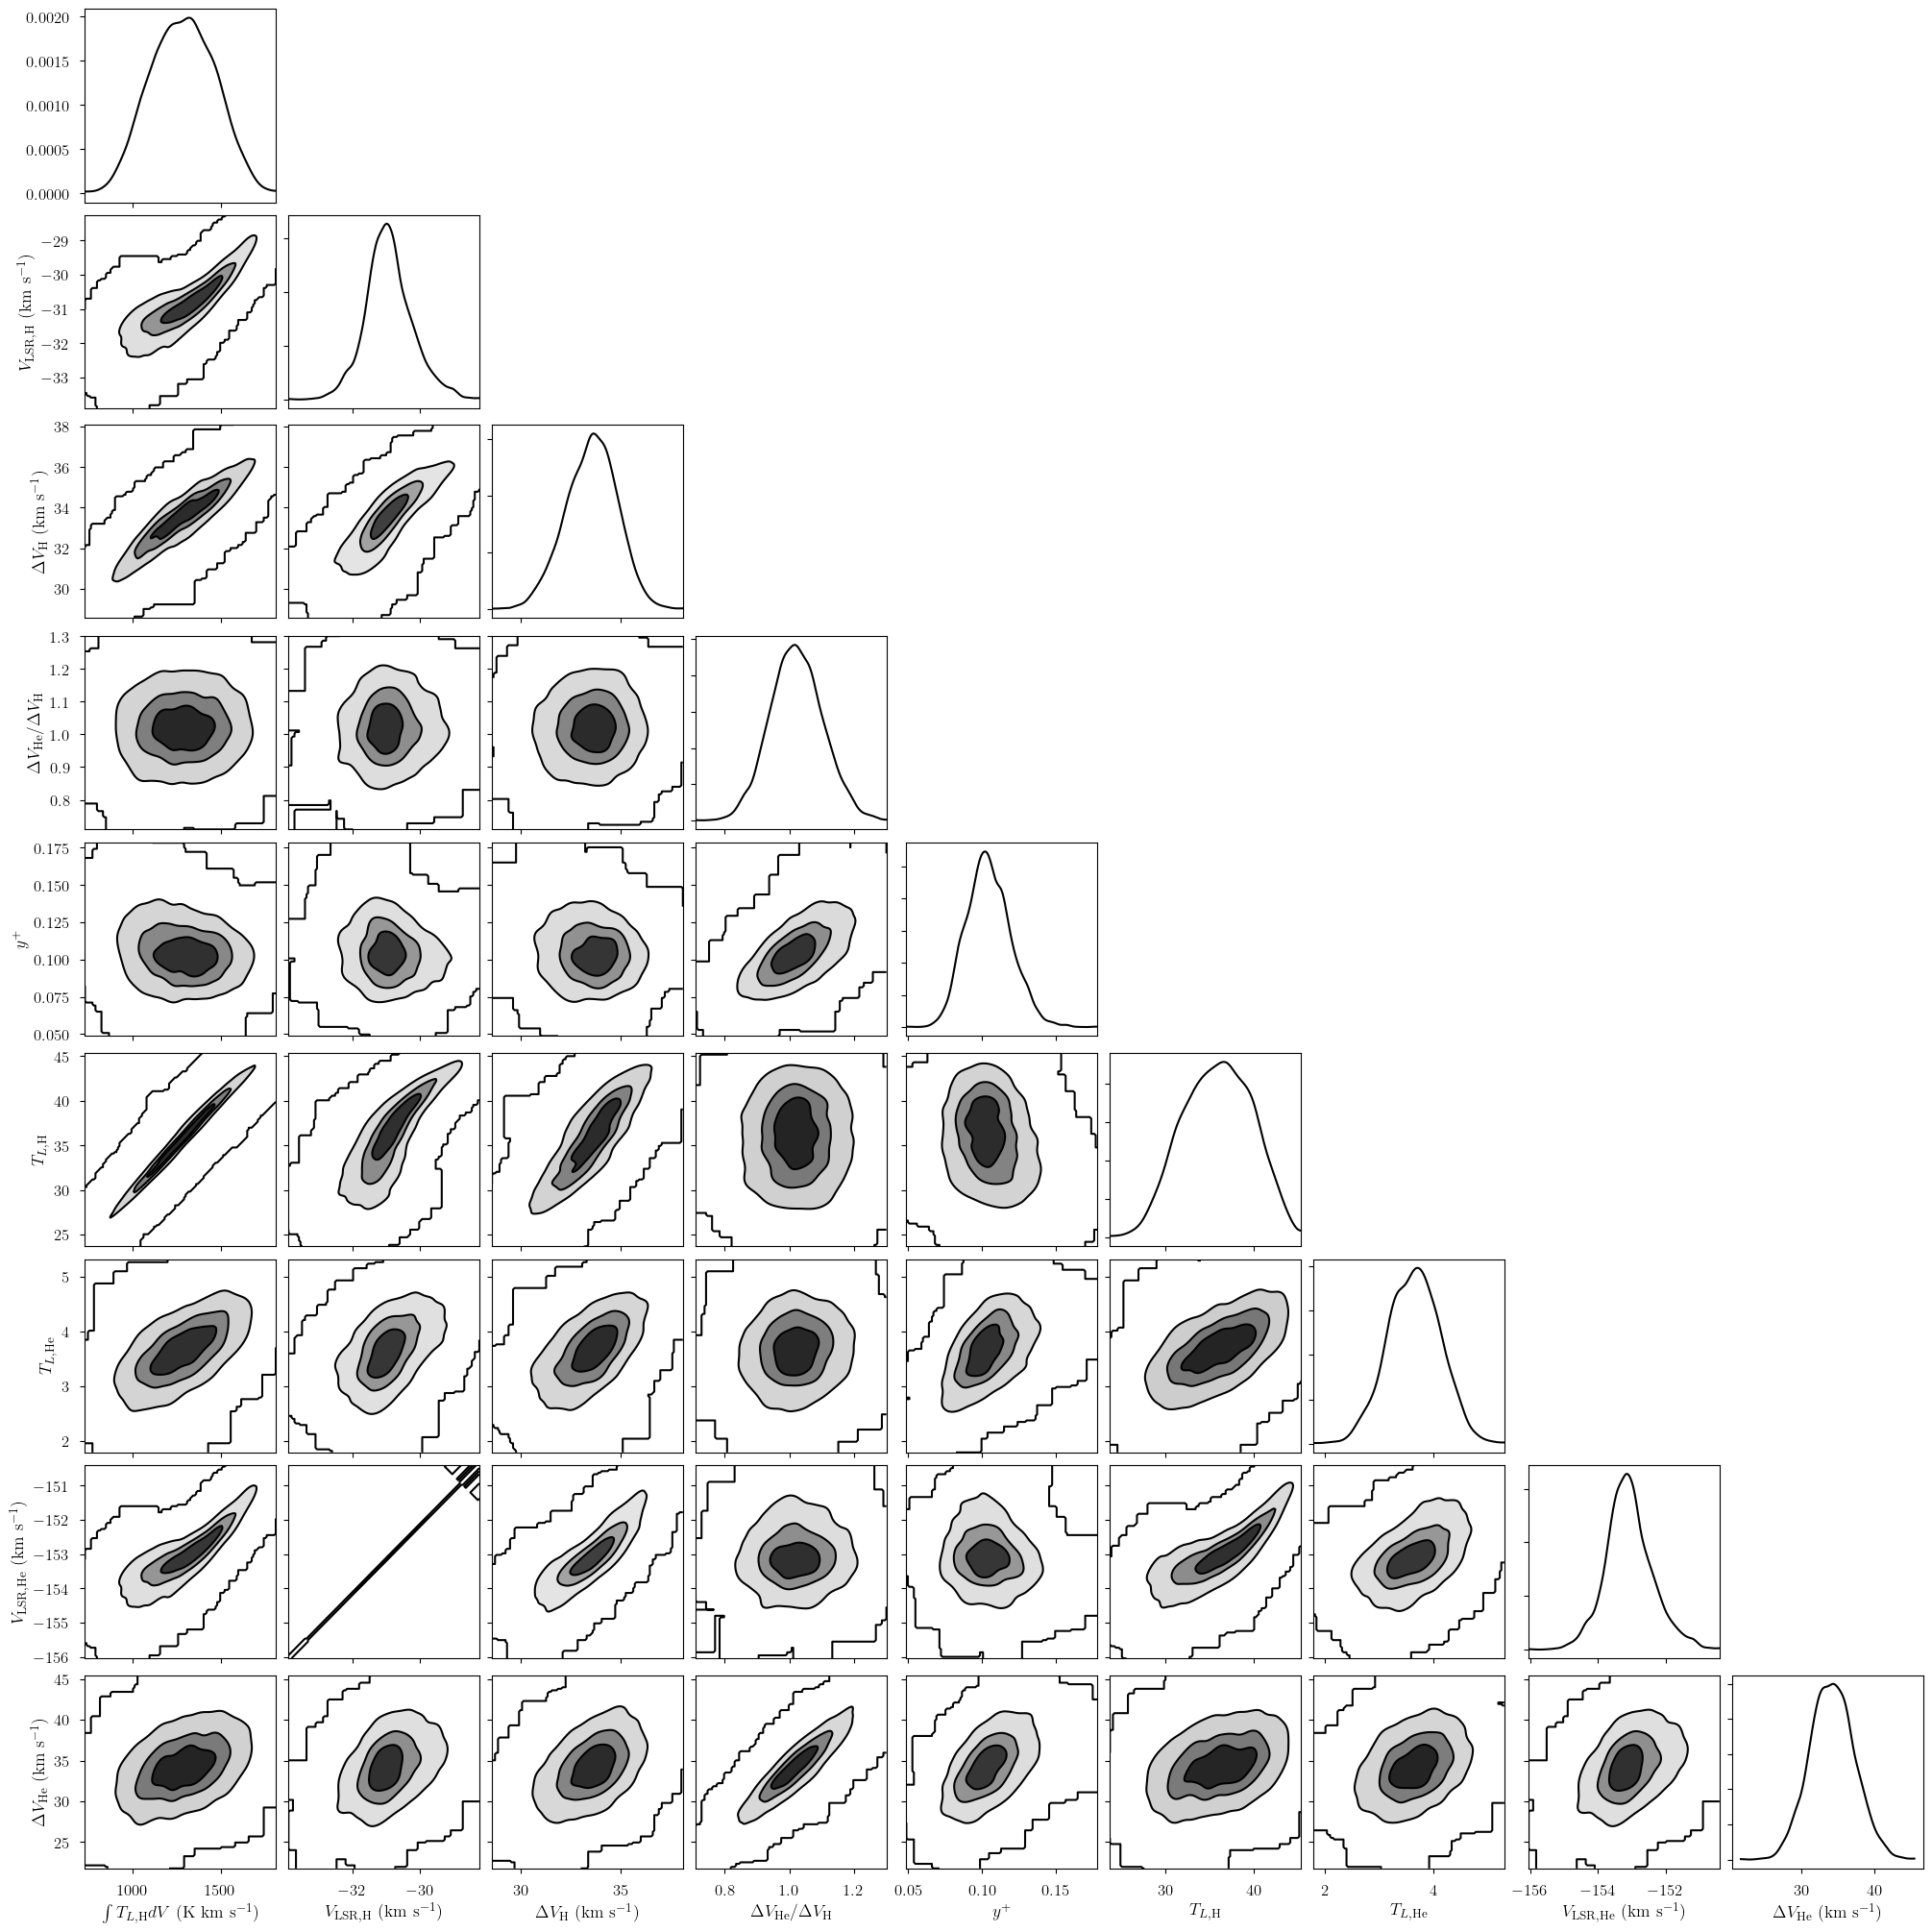

In [20]:
var_names = [param for param in model.deterministics if "rms" not in param]
plot_pair(
    model.trace.solution_0.sel(cloud=0), # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
)

Finally, we can get the posterior statistics, Bayesian Information Criterion (BIC), etc.

In [21]:
point_stats = az.summary(model.trace.solution_0, var_names=model.deterministics, kind='stats', hdi_prob=0.68)
print("BIC:", model.bic())
display(point_stats)

BIC: 866.4880127812378


,mean,sd,hdi_16%,hdi_84%
H_area[0],1284.432,180.367,1118.462,1493.302
H_area[1],1098.851,188.457,910.347,1278.030
H_area[2],1360.793,62.766,1293.130,1412.844
H_center[0],-30.919,0.700,-31.592,-30.318
H_center[1],-2.940,4.643,-8.814,0.482
H_center[2],24.950,0.095,24.864,25.041
H_fwhm[0],33.513,1.285,32.312,34.848
H_fwhm[1],50.679,5.426,46.002,56.124
H_fwhm[2],20.571,0.382,20.170,20.914
He_H_fwhm_ratio[0],1.023,0.081,0.932,1.092
